In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

# Add docstrings to all functions!
# add note about why the loss_hist oscillates so much (because it is not batch gd or even mini-batch gd)
* [super helpful explanations of all types of gradient descent](https://am207.github.io/2017/wiki/gradientdescent.html#stochastic-gradient-descent)

In [14]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=3)
np.place(y, y==0, -1)

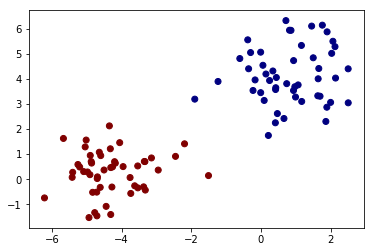

In [15]:
plt.scatter(X[:,0], X[:,1], c=y, cmap = 'jet')

In [16]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

---

In [17]:
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

In [18]:
X = add_intercept(X)
w = np.zeros(len(X[0]))

In [19]:
def hinge_loss(X_i, y_i, weights):
    loss = 1 - y_i * np.dot(weights.T, X_i)
    if loss < 0:
        loss = 0
    return loss

In [20]:
loss = []
for i in range(len(X)):
    loss.append(hinge_loss(X[i], y[i], w))
total_loss = np.sum(loss)
total_loss

100.0

In [21]:
w

array([ 0.,  0.,  0.])

In [22]:
learning_rate = 1
num_iters = 1000
w = np.zeros(len(X[0]))
# lambda = 1/iteration
loss_hist = []

def Stochastic_Gradient_Descent(X, y, learning_rate, num_iters):
    #X = add_intercept(X)
    weights = np.zeros(len(X[0]))
    for iteration in range(1, num_iters):
        for row in range(len(X)):
            loss = hinge_loss(X[row], y[row], weights)
            if loss == 0:
                weights = weights - learning_rate * ((2  * (1/iteration) * weights))
            else:
                weights = weights - learning_rate * ((-y[row] * X[row]) + (2  * (1/iteration) * weights))
    return weights
            

In [23]:
weights = Stochastic_Gradient_Descent(X = X, y=y, learning_rate=1, num_iters = 1000)

In [24]:
weights

array([  2.12889977e-03,  -3.55624119e+00,  -2.75181965e+00])

In [25]:
loss = []
for i in range(len(X)):
    loss.append(hinge_loss(X[i], y[i], weights))
total_loss = np.sum(loss)
total_loss

0

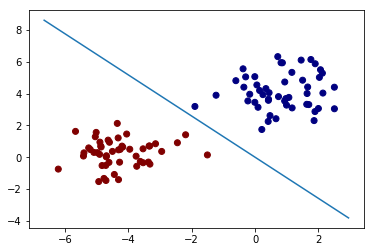

In [26]:
# it works, we've found the perfectly separating hyperplane!
plt.scatter(X[:,1], X[:,2], c=y, cmap = 'jet')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 100)
plt.plot(xx, (-weights[1]/weights[2]) * xx - (weights[0]/weights[2]))

Text(0,0.5,'loss')

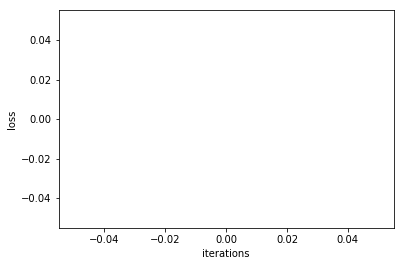

In [58]:
plt.plot(range(len(loss_hist)), loss_hist)
plt.xlabel('iterations')
plt.ylabel('loss')

In [59]:
min(loss_hist)

ValueError: min() arg is an empty sequence

---

---

---

## Statistical Re-sampling
Since the recall was still very low after training our SVM, we will use a statistical re-sampling technique designed for dealing with imbalanced classes, like ours. We'll be using some tools from the [imbalanced-learn package](http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html)

* `Recall` is our metric of choice. [this article](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c) provides a great explanation for why
    * In our instance, we're okay with incorectly guessing that there was alcohol involved with some car crashes, if it means predicting all the instances when there was alcohol involved
    * Generally speaking, when dealing with an imbalanced dataset, oversampling is a good technique to increase recall
* [this](https://beckernick.github.io/oversampling-modeling/) is a great article on the right way to oversmple.

In [24]:
from imblearn.over_sampling import SMOTE

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=742)

In [26]:
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)

In [27]:
print(sorted(Counter(y_train_resampled).items()))

[(0, 52717), (1, 52717)]


In [28]:
clf = SVC(kernel='linear')
clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.91      0.95     17543
          1       0.30      0.94      0.46       702

avg / total       0.97      0.91      0.93     18245



In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)
print('\n', confusion_matrix(y_test, y_pred))

True negatives: 16032
True positives: 657
False negatives: 45
False Positives: 1511

 [[16032  1511]
 [   45   657]]


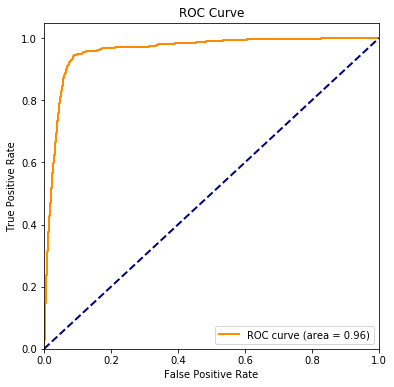

In [32]:
y_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize = (6,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Normalized confusion matrix
[[ 0.91  0.09]
 [ 0.06  0.94]]


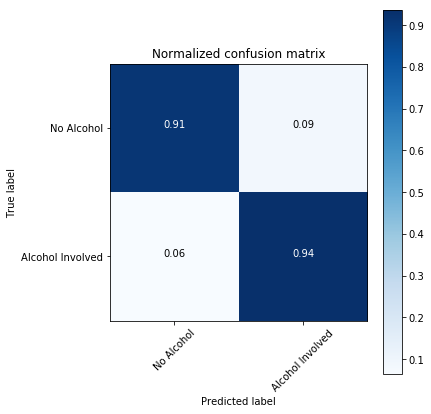

In [34]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=['No Alcohol', 'Alcohol Involved'], normalize=True,
                      title='Normalized confusion matrix')